In [1]:
import os
import sys
# Load the local code
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from src.data.read_parallel import read_parallel_local
import pandas as pd

In [2]:
#!git clone --depth 1 -b v2.3.0 https://github.com/tensorflow/models.git /home/ubuntu/models
#! pip install tensorflow_hub
#! pip install tensorflow_datasets
#!pip install -Uqr /home/ubuntu/models/official/requirements.txt


In [7]:

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import sys
sys.path.append('/home/ubuntu/models')
from official.nlp.data import classifier_data_lib
from official.nlp.bert import tokenization
from official.nlp import optimization

import transformers

In [5]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [66]:
REDUCE_BY_FACTOR = 5 # Make the dataset smaller for development purposes
train_test_ratio = 0.91
train_valid_ratio = 0.90
first_n_words = 512

if 'DATA_VOL' not in os.environ:
    # Manually set:
    DATA_VOL = '/datavol'
else:
    DATA_VOL = os.environ['DATA_VOL']
    
# Pre-wrangled metadata
df = pd.read_csv("../references/derived/ml_data.csv", encoding="latin1", parse_dates=True)
df.id = df.id.astype(int)    
print(f"Original number of examples: {len(df)}")
df = df.sample(n=int(len(df)/REDUCE_BY_FACTOR)) #
print(f"Reduced number of examples:  {len(df)}")

tmp = read_parallel_local(df['id'], DATA_VOL + "/clean/")
df['text'] = tmp
df = df.reset_index(drop=True)

Original number of examples: 199646
Reduced number of examples:  39929
Took 0.16564065615336102 min to open 39929 files with 20 processes.


In [67]:
df_train_full, df_test = train_test_split(df, train_size = train_test_ratio, random_state = 1, stratify = df.signed.values)
df_train, df_valid = train_test_split(df_train_full, train_size = train_valid_ratio, random_state = 1, stratify = df_train_full.signed.values)

In [68]:
print(f"Training size: {df_train.shape}")
print(f"Validation size: {df_valid.shape}")
print(f"Test size: {df_test.shape}")

Training size: (32701, 7)
Validation size: (3634, 7)
Test size: (3594, 7)


In [69]:
!nvidia-smi

Tue Mar  2 16:51:19 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.80.02    Driver Version: 450.80.02    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           On   | 00000000:00:1E.0 Off |                    0 |
| N/A   55C    P0    60W / 149W |  10810MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [12]:
#!git clone --depth 1 -b v2.3.0 https://github.com/tensorflow/models.git

In [13]:
#!pip install -Uqr models/official/requirements.txt
#f.device()

In [70]:
train_data1 = tf.data.Dataset.from_tensor_slices((df_train['text'].values, df_train['signed'].values, df_train['partisan_lean'].values))
val_data1   = tf.data.Dataset.from_tensor_slices((df_valid['text'].values, df_valid['signed'].values, df_valid['partisan_lean'].values))
test_data1  = tf.data.Dataset.from_tensor_slices((df_test['text'].values, df_test['signed'].values, df_test['partisan_lean'].values))

In [71]:
train_batch_size = 16
max_seq_length = 128  # Your choice here.

In [72]:
from transformers import TFLongformerModel, LongformerTokenizer

longformer = TFLongformerModel.from_pretrained('allenai/longformer-base-4096')
label_list = [0,1]

Some layers from the model checkpoint at allenai/longformer-base-4096 were not used when initializing TFLongformerModel: ['lm_head']
- This IS expected if you are initializing TFLongformerModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFLongformerModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFLongformerModel were initialized from the model checkpoint at allenai/longformer-base-4096.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFLongformerModel for predictions without further training.


In [18]:
# bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2",
#                             trainable=True)
# vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
# do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
# tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)
# label_list = [0,1]

In [37]:
#tokenizer(df['text'][1], model_max_length=10)
#tokenizer = LongformerTokenizer.from_pretrained("allenai/longformer-large-4096")

In [100]:
tokenizer = LongformerTokenizer.from_pretrained( \
  "allenai/longformer-large-4096")
#a = tokenizer(df['text'][0])
a = tokenizer(df['text'][0], padding='max_length', max_length=max_seq_length, truncation=True)
len(a['input_ids'])

128

array(["101st general assembly state of illinois and hb0306 introduced by rep. david mcsweeney synopsis as introduced: ilcs 5/3-5018.2 new amends the counties code. provides that a county board may, by ordinance, assume control over county recorder fees. provides that, upon the adoption of such an ordinance, the county board may reduce any fee charged by the county recorder of deeds to a figure selected by the county board and transfer all or part of a county recorder of deed's budget surplus to the county general fund. provides that county board actions under these provisions have precedence over other formulas or fee schedules used to calculate county recorder fees and any other use of a county recorder of deed's budget surplus. effective immediately. lrb101 awj b fiscal note act may apply a bill for hb0306 lrb101 awj b an act concerning local government. be it enacted by the people of the state of illinois, represented in the general assembly: the counties code is amended by adding 

In [101]:
def to_feature(text, label, partisan_lean, label_list=label_list, tokenizer=tokenizer):
    """
    Inputs:
    text - str - Raw text string to tokenize
    label - int - Class label in label_list
    partisan_lean - float - Partisan lean 
    
    Outputs:
    input_ids - list[int] - encoded tokens for the tokenizer
    attention_mask - list[int] - ??
    label - label pass through
    partisan_lean - pass through
    """
    
    feature = tokenizer(text, padding='max_length', max_length=max_seq_length, truncation=True)
    return (feature.input_ids, feature.attention_mask, label,  partisan_lean)



In [102]:
t = to_feature(df['text'][0], df['signed'][0], 0.07)
print(len(t))
print(len(t[0]))

4
128


In [106]:
def to_feature_map(text, label, partisan_lean):
    input_ids, input_mask, label_id, partisan_lean  \
       = tf.py_function(to_feature, [text, label, partisan_lean], Tout = [tf.int32, tf.int32, tf.int32, tf.float32])
    
    input_ids.set_shape([max_seq_length])
    input_mask.set_shape([max_seq_length])
    label_id.set_shape([])
    partisan_lean.set_shape([])
    
    x = {
        'input_word_ids': input_ids,
        'input_mask': input_mask,
        'partisan_lean': partisan_lean
    }
    
    return (x, label_id)
    
    

In [107]:
with tf.device('/cpu:0'):
    train_data = (train_data1.map(to_feature_map, num_parallel_calls=tf.data.experimental.AUTOTUNE)
             
             .shuffle(1000)
             .batch(train_batch_size, drop_remainder=True)
             .prefetch(tf.data.experimental.AUTOTUNE) 
             )

    val_data = (val_data1.map(to_feature_map, num_parallel_calls=tf.data.experimental.AUTOTUNE)
             .batch(train_batch_size, drop_remainder=True)
             .prefetch(tf.data.experimental.AUTOTUNE) 
            )

In [108]:
val_data.element_spec

({'input_word_ids': TensorSpec(shape=(16, 128), dtype=tf.int32, name=None),
  'input_mask': TensorSpec(shape=(16, 128), dtype=tf.int32, name=None),
  'partisan_lean': TensorSpec(shape=(16,), dtype=tf.float32, name=None)},
 TensorSpec(shape=(16,), dtype=tf.int32, name=None))

In [117]:
def create_model_1():
    
        input_word_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="input_word_ids")
        input_mask = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="input_mask")
        partisan_lean = tf.keras.layers.Input(shape=(1,), dtype=tf.float34, name="partisan_lean")
        
        longformer = TFLongformerModel.from_pretrained('allenai/longformer-base-4096')
        lf_outputs = longformer(input_word_ids)
        #pooled_output = lf_outputs[:,0,:]
        
        #drop = tf.keras.layers.Dropout(0.4)(pooled_output)
        #concat = tf.keras.layers.concatenate([drop, partisan_lean], axis=1)
        #output = tf.keras.layers.Dense(1, activation='sigmoid')(concat)
        
        model = tf.keras.Model(
          inputs={
              'input_word_ids': input_word_ids,
              'input_mask': input_mask,
              'input_type_ids': input_type_ids,
              'partisan_lean': partisan_lean
          },
          outputs=lf_outputs
        )
        return model

In [118]:
model = create_model_1()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics = [tf.keras.metrics.BinaryAccuracy()])
model.summary()

AttributeError: module 'tensorflow' has no attribute 'float34'

In [120]:
input_ids = tf.keras.layers.Input(shape=(128,), name='input_token', dtype='int32')
input_masks_ids = tf.keras.layers.Input(shape=(128,), name='masked_token', dtype='int32')
longformer2 = TFLongformerModel.from_pretrained('allenai/longformer-base-4096')[0]
X = longformer2(input_ids, input_masks_ids)
model = tf.keras.Model(inputs=[input_ids, input_masks_ids], outputs = X)

Some layers from the model checkpoint at allenai/longformer-base-4096 were not used when initializing TFLongformerModel: ['lm_head']
- This IS expected if you are initializing TFLongformerModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFLongformerModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFLongformerModel were initialized from the model checkpoint at allenai/longformer-base-4096.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFLongformerModel for predictions without further training.


TypeError: 'TFLongformerModel' object is not subscriptable

In [25]:
#import pydot
#tf.keras.utils.plot_model(model=model, show_shapes=True, dpi=76)

In [26]:
epochs = 4
history = model.fit(train_data,
                   validation_data=val_data,
                   epochs=epochs,
                   verbose=1)

Epoch 1/4
2043/2043 [==============================] - 1797s 867ms/step - loss: 0.3621 - binary_accuracy: 0.8587 - val_loss: 0.2382 - val_binary_accuracy: 0.9086
Epoch 2/4
2043/2043 [==============================] - 1787s 870ms/step - loss: 0.2414 - binary_accuracy: 0.9027 - val_loss: 0.2253 - val_binary_accuracy: 0.9094
Epoch 3/4
2043/2043 [==============================] - 1787s 870ms/step - loss: 0.2151 - binary_accuracy: 0.9153 - val_loss: 0.2307 - val_binary_accuracy: 0.9091
Epoch 4/4
2043/2043 [==============================] - 1785s 869ms/step - loss: 0.1899 - binary_accuracy: 0.9247 - val_loss: 0.2590 - val_binary_accuracy: 0.9094


In [27]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history["val_"+metric], "")
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])
    plt.show()

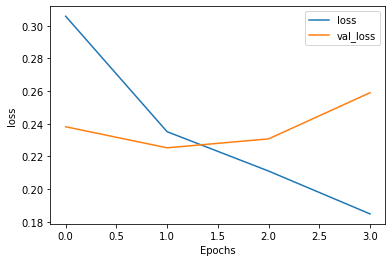

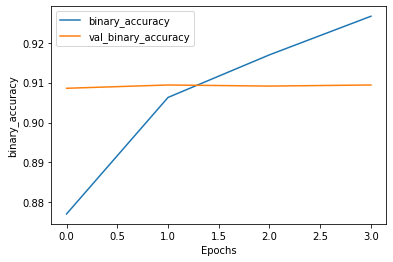

In [28]:
plot_graphs(history, 'loss')
plot_graphs(history, 'binary_accuracy')

In [29]:
history.history.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

In [30]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [31]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [137]:
from transformers.models.longformer.modeling_tf_longformer import *
from transformers import TFLongformerMainLayer, LongformerConfig
import tensorflow as tf

long = 'allenai/longformer-base-4096'
transformer_model = TFLongformerMainLayer.from_pretrained(long)

input_ids = tf.keras.layers.Input(shape=(128,), name='input_token', dtype='int32')
input_masks_ids = tf.keras.layers.Input(shape=(128,), name='masked_token', dtype='int32')
X = transformer_model(input_ids, input_masks_ids)
model = tf.keras.Model(inputs=[input_ids, input_masks_ids], outputs = X)

ImportError: cannot import name 'TFLongformerMainLayer' from 'transformers' (unknown location)

In [128]:
from transformers import LongformerTokenizer, TFLongformerForSequenceClassification
import tensorflow as tf

tokenizer = LongformerTokenizer.from_pretrained('allenai/longformer-base-4096')
model = TFLongformerForSequenceClassification.from_pretrained('allenai/longformer-base-4096')

inputs = tokenizer("Hello, my dog is cute", return_tensors="tf")
inputs["labels"] = tf.reshape(tf.constant(1), (-1, 1)) # Batch size 1

outputs = model(inputs)
loss = outputs.loss
logits = outputs.logits

Some layers from the model checkpoint at allenai/longformer-base-4096 were not used when initializing TFLongformerForSequenceClassification: ['lm_head']
- This IS expected if you are initializing TFLongformerForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFLongformerForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFLongformerForSequenceClassification were not initialized from the model checkpoint at allenai/longformer-base-4096 and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [129]:
inputs

{'input_ids': <tf.Tensor: shape=(1, 8), dtype=int32, numpy=
array([[    0, 31414,     6,   127,  2335,    16, 11962,     2]],
      dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(1, 8), dtype=int32, numpy=array([[1, 1, 1, 1, 1, 1, 1, 1]], dtype=int32)>, 'labels': <tf.Tensor: shape=(1, 1), dtype=int32, numpy=array([[1]], dtype=int32)>}

In [131]:
type(model)

transformers.models.longformer.modeling_tf_longformer.TFLongformerForSequenceClassification

In [133]:
outputs

TFLongformerSequenceClassifierOutput(loss=<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.73660505], dtype=float32)>, logits=<tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[0.09840831, 0.01330276]], dtype=float32)>, hidden_states=None, attentions=None, global_attentions=None)